In [1]:
import os
from huggingface_hub import hf_hub_download
from pathlib import Path
from time import time

C:\Users\akhan147\Anaconda3\envs\trader\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [24]:
repo_dir = Path('.').absolute().parent


# Download a hugging face model & make a Ollama modelfile
* Download huggingface CLI - [Hugging Face Hub](https://huggingface.co/docs/huggingface_hub/main/en/guides/cli)
* Login to Hugging face - `huggingface-cli login --token $HUGGINGFACE_TOKEN`
* `huggingface-cli whoami`
* Download a llm model - specifically GGUF one - [GGUF model download](https://www.youtube.com/watch?v=7BH4C6-HP14)
* Write a `modelfile` : `FROM ./huggingface_models/mistral-7b-instruct-v0.2.Q4_K_M.gguf`
* Create a model: `ollama create mistrallite -f mistral_lite_modelfile`

# RAG - Intro

* RAG stands for Retrieval Augmented Generation, and it's a way to index a data source so that we can combine it with an LLM.
* This gives us an AI chat experience that can leverage that data.

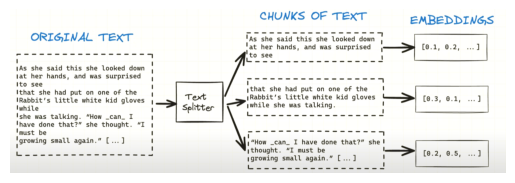

In [3]:
# Add rag_basic image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread(repo_dir / 'notes' / 'rag_basic.png')
# img = img.resize((15, 10))
plt.imshow(img)
plt.axis('off')  # Hide axes

plt.show()


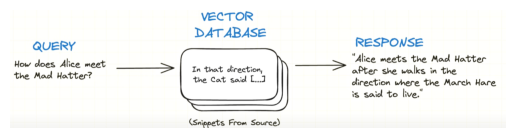

In [4]:
img = mpimg.imread(repo_dir / 'notes' / 'rag_basic2.png')
# img = img.resize((15, 10))
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()


* First, we have our original data source, the PDFs.
* This data is going to be split into small chunks and then transformed into an embedding and stored inside of the vector database.
* Then when we want to ask a question, we'll also turn our query into an embedding.
* This will let us fetch the most relevant entries from the database.
* We can then use those entries together in a prompt and that's how we get our final response.

# Load Docs

In [5]:
from langchain.document_loaders.pdf import PyPDFDirectoryLoader

DATA_PATH = repo_dir / 'data'

def load_documents():
    document_loader = PyPDFDirectoryLoader(DATA_PATH)
    return document_loader.load()

In [6]:
# Create (or update) the data store.
start_time = time()

documents = load_documents()
print('\n Time taken: ', time() - start_time)
# documents[0]



 Time taken:  0.6011416912078857


* So each document is basically an object containing the text content of each page in the PDF. 
* It also has some metadata attached, which tells you the page number and the source of the text.

In [7]:
# Extract the page_content from each document
page_contents = [doc.page_content for doc in documents]

# If you want to access the page_content of the first document
first_page_content = page_contents[0]
print(first_page_content)

MONOPOLY 
Property Trading Game from Parker Brothers" 
AGES 8+ 
2 to 8 Players 
Contents: Gameboard, 3 dice, tokens, 32 houses, I2 hotels, Chance 
and Community Chest cards, Title Deed cards, play money and a Banker's tray. 
Now there's a faster way to play MONOPOLY. Choose to play by 
the classic rules for buying, renting and selling properties or use the 
Speed Die to get into the action faster. If you've never played the classic 
MONOPOLY game, refer to the Classic Rules beginning on the next page. 
If you already know how to play and want to use the Speed Die, just 
read the section below for the additional Speed Die rules. 
SPEED DIE RULES 
Learnins how to Play with the S~eed Die IS as 
/ 
fast as playing with i't. 
1. When starting the game, hand out an extra $1,000 to each player 
(two $5005 should work). The game moves fast and you'll need 
the extra cash to buy and build. 
2. Do not use the Speed Die until you've landed on or passed over 
GO for the first time. Once you collec

## Chunk

In [8]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.schema.document import Document

def split_documents(documents: list[Document]):
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=800,
        chunk_overlap=80,
        length_function=len,
        is_separator_regex=False,
    )
    return text_splitter.split_documents(documents)

In [9]:
start_time = time()

documents = load_documents()
chunks = split_documents(documents)
print(chunks[0])

print('\n Time taken: ', time() - start_time)

page_content='MONOPOLY 
Property Trading Game from Parker Brothers" 
AGES 8+ 
2 to 8 Players 
Contents: Gameboard, 3 dice, tokens, 32 houses, I2 hotels, Chance 
and Community Chest cards, Title Deed cards, play money and a Banker's tray. 
Now there's a faster way to play MONOPOLY. Choose to play by 
the classic rules for buying, renting and selling properties or use the 
Speed Die to get into the action faster. If you've never played the classic 
MONOPOLY game, refer to the Classic Rules beginning on the next page. 
If you already know how to play and want to use the Speed Die, just 
read the section below for the additional Speed Die rules. 
SPEED DIE RULES 
Learnins how to Play with the S~eed Die IS as 
/ 
fast as playing with i't. 
1. When starting the game, hand out an extra $1,000 to each player' metadata={'source': 'G:\\My Drive\\Slate\\Notes_G\\Finance Job\\python for finance\\potfolio_optimization\\data\\monopoly.pdf', 'page': 0}

 Time taken:  0.47827720642089844


## Chuck Ids

We'll use the source path, the page number, and then the chunk number of that page.

In [10]:
def calculate_chunk_ids(chunks):

    # This will create IDs like "data/monopoly.pdf:6:2"
    # Page Source : Page Number : Chunk Index

    last_page_id = None
    current_chunk_index = 0

    for chunk in chunks:
        source = chunk.metadata.get("source")
        source = source[source.find('data') : ]
        
        page = chunk.metadata.get("page")
        
        current_page_id = f"{source}:{page}"

        # If the page ID is the same as the last one, increment the index.
        if current_page_id == last_page_id:
            current_chunk_index += 1
        else:
            current_chunk_index = 0

        # Calculate the chunk ID.
        chunk_id = f"{current_page_id}:{current_chunk_index}"
        last_page_id = current_page_id

        # Add it to the page meta-data.
        chunk.metadata["id"] = chunk_id

    return chunks

# Embedding Functions & VectorDB

In [11]:
# function returns embedding function
# used at 2 places - 
# The first is going to be when we create the database itself. 
# And the second is when we actually want to query the database

from langchain_community.embeddings.ollama import OllamaEmbeddings
# from langchain_community.embeddings.bedrock import BedrockEmbeddings


def get_embedding_function():
    # embeddings = BedrockEmbeddings(
    #     credentials_profile_name="default", region_name="us-east-1"
    # )
    embeddings = OllamaEmbeddings(model="nomic-embed-text") # if completely local
    return embeddings

In [12]:
CHROMA_PATH = "chroma"


In [13]:
from langchain.vectorstores.chroma import Chroma

def add_to_chroma(chunks: list[Document]):
    # Load the existing database.
    db = Chroma(
        persist_directory=CHROMA_PATH, embedding_function=get_embedding_function()
    )

    # Calculate Page IDs.
    chunks_with_ids = calculate_chunk_ids(chunks)

    # Add or Update the documents.
    existing_items = db.get(include=[])  # IDs are always included by default
    existing_ids = set(existing_items["ids"])
    print(f"Number of existing documents in DB: {len(existing_ids)}")

    # Only add documents that don't exist in the DB.
    new_chunks = []
    for chunk in chunks_with_ids:
        if chunk.metadata["id"] not in existing_ids:
            new_chunks.append(chunk)

    if len(new_chunks):
        print(f"👉 Adding new documents: {len(new_chunks)}")
        new_chunk_ids = [chunk.metadata["id"] for chunk in new_chunks]
        db.add_documents(new_chunks, ids=new_chunk_ids)
        db.persist()
    else:
        print("✅ No new documents to add")

In [14]:
start_time = time()
add_to_chroma(chunks)

print('\n Time taken: ', time() - start_time)

C:\Users\akhan147\AppData\Local\Temp\ipykernel_17972\2203180553.py:5: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  db = Chroma(


Number of existing documents in DB: 0
👉 Adding new documents: 41

 Time taken:  90.04852056503296


C:\Users\akhan147\AppData\Local\Temp\ipykernel_17972\2203180553.py:27: LangChainDeprecationWarning: Since Chroma 0.4.x the manual persistence method is no longer supported as docs are automatically persisted.
  db.persist()


In [15]:
import shutil
import os
def clear_database():
    if os.path.exists(CHROMA_PATH):
        shutil.rmtree(CHROMA_PATH)

In [16]:
# clear_database()

# Running RAG 

In [17]:
PROMPT_TEMPLATE = """
Answer the question based only on the following context:

{context}

---

Answer the question based on the above context: {question}
"""

In [18]:
from langchain.prompts import ChatPromptTemplate
from langchain_community.llms.ollama import Ollama

def query_rag(query_text: str):
    # Prepare the DB.
    embedding_function = get_embedding_function()
    db = Chroma(persist_directory=CHROMA_PATH, embedding_function=embedding_function)

    # Search the DB. Gives k most relevant chunks to the query
    results = db.similarity_search_with_score(query_text, k=5)

    context_text = "\n\n---\n\n".join([doc.page_content for doc, _score in results])
    prompt_template = ChatPromptTemplate.from_template(PROMPT_TEMPLATE)
    prompt = prompt_template.format(context=context_text, question=query_text)
    # print(prompt)

    model = Ollama(model="mistrallite:latest")
    response_text = model.invoke(prompt)

    sources = [doc.metadata.get("id", None) for doc, _score in results]
    formatted_response = f"Response: {response_text}\nSources: {sources}"
    print(formatted_response)
    return response_text

In [19]:
start_time = time()

query_text = 'How do I get out of jain in Monopoly?'
query_rag(query_text)

print('\n Time taken: ', time() - start_time)

Response:  To get out of jail in Monopoly according to the context provided, you need to roll doubles with the white dice during your turn. Once you roll doubles, you will move your token according to the sum of the two dice and out of the jail space. If you are unable to roll doubles during your turn, your turn ends and the next player takes their turn.
Sources: ['data\\monopoly.pdf:1:0', 'data\\monopoly.pdf:1:1', 'data\\ticket_to_ride.pdf:1:1', 'data\\monopoly.pdf:0:0', 'data\\monopoly.pdf:2:2']

 Time taken:  31.971503257751465


# Test LLM

In [20]:
EVAL_PROMPT = """
Expected Response: {expected_response}
Actual Response: {actual_response}
---
(Answer with 'true' or 'false') Does the actual response match the expected response? 
"""

In [21]:
def query_and_validate(question: str, expected_response: str):
    response_text = query_rag(question)
    prompt = EVAL_PROMPT.format(
        expected_response=expected_response, actual_response=response_text
    )

    model = Ollama(model="mistrallite:latest")
    evaluation_results_str = model.invoke(prompt)
    evaluation_results_str_cleaned = evaluation_results_str.strip().lower()

    print(prompt)

    if "true" in evaluation_results_str_cleaned:
        # Print response in Green if it is correct.
        print("\033[92m" + f"Response: {evaluation_results_str_cleaned}" + "\033[0m")
        return True
    elif "false" in evaluation_results_str_cleaned:
        # Print response in Red if it is incorrect.
        print("\033[91m" + f"Response: {evaluation_results_str_cleaned}" + "\033[0m")
        return False
    else:
        raise ValueError(
            f"Invalid evaluation result. Cannot determine if 'true' or 'false'."
        )

In [22]:
start_time = time()

assert query_and_validate(
    question="How much total money does a player start with in Monopoly? (Answer with the number only)",
    expected_response="$1500",
)

print('\n Time taken: ', time() - start_time)

Response:  A player starts with $1,500 in Monopoly.
Sources: ['data\\monopoly.pdf:0:0', 'data\\monopoly.pdf:0:1', 'data\\monopoly.pdf:2:0', 'data\\monopoly.pdf:1:2', 'data\\monopoly.pdf:2:1']

Expected Response: $1500
Actual Response:  A player starts with $1,500 in Monopoly.
---
(Answer with 'true' or 'false') Does the actual response match the expected response? 

Response: true. the actual response describes a situation where a player starts the game of monopoly with $1,500, which is equivalent to the expected response of having a starting amount of $1,500.

 Time taken:  27.884098768234253


In [23]:
start_time = time()

assert query_and_validate(
    question="How many points does the longest continuous train get in Ticket to Ride? (Answer with the number only)",
    expected_response="10 points",
)

print('\n Time taken: ', time() - start_time)

Response:  The longest continuous train gets a bonus of 10 points.
Sources: ['data\\ticket_to_ride.pdf:3:3', 'data\\ticket_to_ride.pdf:1:3', 'data\\ticket_to_ride.pdf:3:2', 'data\\ticket_to_ride.pdf:0:1', 'data\\ticket_to_ride.pdf:3:1']

Expected Response: 10 points
Actual Response:  The longest continuous train gets a bonus of 10 points.
---
(Answer with 'true' or 'false') Does the actual response match the expected response? 

Response: true. in the given context, both the expected and actual responses mean that a bonus of 10 points is given for having the longest continuous train.

 Time taken:  24.800504207611084
